<a href="https://colab.research.google.com/github/nv-hiep/Autoregressive_Models/blob/main/Autoregressive_Models_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn
import torch.utils.data
import math
import numpy as np
import seaborn
import pandas as pd

# Problem

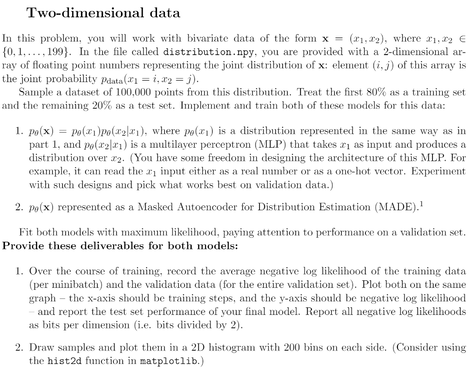

"Part I" means Autoregressive_Models_1D (pls refer to Autoregressive_Models_2D.pynb)

From Part-I:

Let $\theta = (\theta_{1}, ..., \theta_{100}) \in \mathbb{R}^{100}$, and define the model:

$p_{\theta}(x) = \frac{e^{\theta_{x}}}{\sum_{x'}{e^{\theta_{x'}}}}$

Fit $p_{\theta}$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

# Data

In [2]:
distribution = np.load('distribution.npy')

In [3]:
distribution.shape

(200, 200)

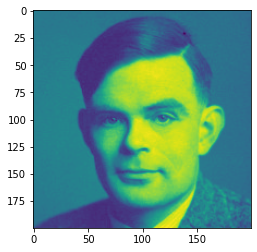

In [4]:
plt.imshow(distribution)
plt.show()

# Sample

In [5]:
samples = np.random.choice(np.arange(len(distribution.ravel())), p=distribution.ravel(), size=100000)
samples_x = samples % 200
samples_y = samples // 200
print('Sample x: ', samples_x.shape)
print('Sample y: ', samples_y.shape)

Sample x:  (100000,)
Sample y:  (100000,)


In [7]:
samples_x[:20]

array([136, 183,  97, 104,  40,  70,   2,  46,  71, 110, 103,   7,  20,
       137,  11, 111, 193,   1, 152, 181])

In [8]:
samples_y[:20]

array([ 59,  93,  82,  60,  35,  25, 157, 174,   7, 127, 139,  94, 130,
       152,  85,   3, 169, 153, 108, 170])

Training and test sets

In [9]:
samples = np.stack([samples_x, samples_y], axis=1)
n = len(samples)
train = samples[0:int(0.8*n)]
test = samples[int(0.8*n):]

In [13]:
df = pd.DataFrame({'x':samples_x, 'y':samples_y})

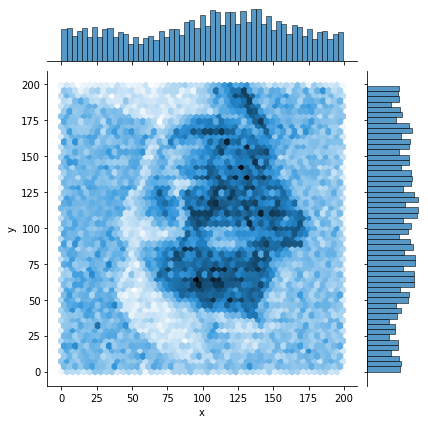

In [16]:
seaborn.jointplot(data=df, x='x', y='y', kind='hex')

In [17]:
from torch.autograd import Variable

batch_size = 1000
n = 200
epochs = 30

# Initialize params theta
theta = torch.zeros(n, requires_grad=True)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
  '''
  Multi-layer Perceptron (MLP)
  '''
  def __init__(self):
    super(MLP, self).__init__()
    self.fc = nn.Linear(n,n)
    self.fc2= nn.Linear(n,n)
    self.theta = nn.Parameter(torch.zeros(n,requires_grad=True))

  def forward(self, x):
    onehot = F.one_hot(x[:,0].long(), num_classes=200)
    onehot = onehot.float()


    _theta=torch.exp(self.theta) / torch.sum(torch.exp(self.theta))
    prob = torch.gather(_theta,dim=0, index=x[:,0].long())

    prob2 = nn.functional.relu(self.fc(onehot))
    prob2 = nn.functional.relu(self.fc2(prob2))
    prob2 = nn.functional.softmax(prob2)

    prob2=torch.gather(prob2.T, dim=0, index=x[:,1].unsqueeze(0).long())

    return prob2, prob

  def loss(self, x):
    px2x1 ,px1 = self.forward(x)
    loss = -torch.sum(torch.log2(px1+1e-10) + torch.log2(px2x1+1e-10))/(2*px2x1.shape[1])

    return loss

In [20]:
# MPL model
net = MLP()
net

MLP(
  (fc): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
)

In [21]:
optimizer = torch.optim.Adam(net.parameters(), lr=1.e-3, weight_decay=0.0001)

In [22]:
for param in net.parameters():
  print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])


Create training and validation interators with size = batch_size

In [23]:
train_iter = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
val_iter   = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=True)

Training...

In [24]:
losses = []
val_losses = []

for epoch in range(epochs):
  loss = 0

  for train_batch in train_iter:
    loss = net.loss(train_batch)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.data.numpy())
    del loss
    loss = 0
      
  with torch.set_grad_enabled(False):
    val_loss = net.loss(torch.from_numpy(test))
    val_losses.append(val_loss.data.numpy())
      
  if epoch % 10 ==0:
    print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 7.633484840393066 val_loss 7.635704040527344 
Epoch 10: loss 7.588993549346924 val_loss 7.619561672210693 
Epoch 20: loss 7.592230319976807 val_loss 7.621018886566162 


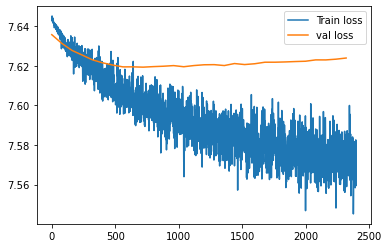

In [25]:
plt.plot(losses, label = 'Train loss')
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = 'val loss')
plt.legend()
plt.show()

Prediction...

In [26]:
p1, p2 = net.forward(torch.from_numpy(test))
p1 = p1.detach().numpy()
p2 = p2.detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


From Part-I:

Let $\theta = (\theta_{1}, ..., \theta_{100}) \in \mathbb{R}^{100}$, and define the model:

$p_{\theta}(x) = \frac{e^{\theta_{x}}}{\sum_{x'}{e^{\theta_{x'}}}}$

In [27]:
theta = net.theta
p1_theta = torch.exp(theta)/torch.sum(torch.exp(theta))
p1_theta = p1_theta.detach().numpy()

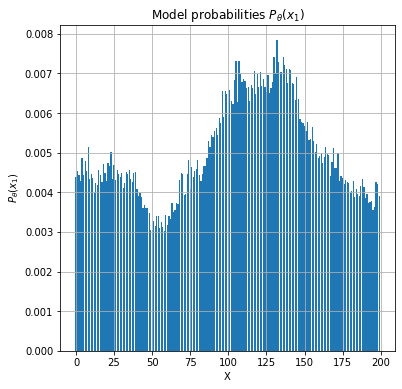

In [39]:
plt.figure(figsize=(6,6))
plt.bar(np.arange(len(p1_theta)), p1_theta)
plt.title(r'Model probabilities $P_{\theta}(x_1)$')
plt.xlabel('X')
plt.ylabel(r'$P_{\theta}(x_1)$')
plt.grid(True)
plt.show()

# Sampling data

Recall the Data distributions

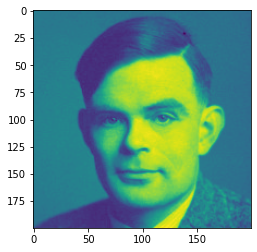

In [40]:
plt.imshow(distribution)
plt.show()

In [41]:
idx = [(x, y) for x in range(200) for y in range(200)]

In [43]:
p_1, p_2 = net.forward(torch.from_numpy(np.array(idx)))

# The joint probabilities
sample_data = p_2*p_1

sample_data = sample_data.reshape(200,200).T.detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


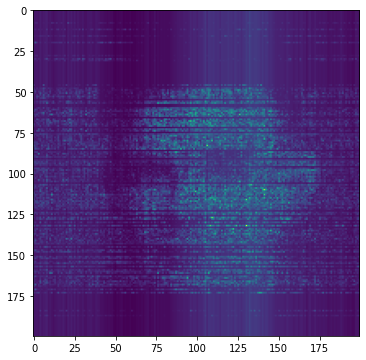

In [44]:
plt.figure(figsize=(6,6))
plt.imshow(sample_data)
plt.show()

# MADE for $P_{\theta}(\mathbf{x})$

MADE: Masked Autoencoder for Distribution Estimation

In [46]:
# Size of 2d distribution
n = 200

The masked linear connection

In [45]:
class MaskedLinear(nn.Linear):
  #Linear with mask
  def __init__(self, in_features, out_features, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', torch.ones(out_features, in_features))
      
  def set_mask(self, mask):
    self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
      
  def forward(self, input):
    return F.linear(input, self.mask * self.weight, self.bias)

In [47]:
class MADE(nn.Module):
  def __init__(self, hidden_sizes, natural_ordering=False):
    super().__init__()
    self.hidden_sizes = hidden_sizes

    #Compute h0
    layers = [MaskedLinear(n,hidden_sizes[0])]

    layers = []
    #compute h^l for l=1..L
    for m in range(0,len(hidden_sizes)-1):
      layers.append(nn.ReLU())
      layers.append(MaskedLinear(hidden_sizes[m], hidden_sizes[m+1]))
    layers.append(nn.ReLU())
    layers.append(MaskedLinear(hidden_sizes[-1], n))
    #compute x_hat

    self.net = nn.Sequential(*layers)
    self.softmax = nn.Softmax()

    self.seed = 0 
    self.m = []
    self.make_masks()
      
  def make_masks(self):
    L = len(self.hidden_sizes)

    #rng = np.random.RandomState(self.seed)
    #self.seed = (self.seed + 1)

    np.random.seed(self.seed)
    self.seed = (self.seed + 1)

    #sampling m^l vectors
    self.m.append(np.random.randint(0,high=n,size=n))
    for l in range(L):
      self.m.append(np.random.randint(self.m[l].min(),high=n,size=self.hidden_sizes[l]))

    # construct masks
    masks = [self.m[l][:,None] <= self.m[l+1][None,:] for l in range(L)]
    masks.append(self.m[L][:,None] < self.m[0][None,:])
            

    # multiply the masks on each linear layer
    layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
    for l,m in zip(layers, masks):
      l.set_mask(m)

  def forward(self, x):
    onehot1 = F.one_hot(x[:,0].long(), num_classes=n).float()

    #onehot = torch.cat((onehot1, onehot2), 1)
    
    out  = self.net(onehot1)#.view(-1,2,n)
    sout = F.softmax(out)
    prob1 = torch.gather(sout.T, dim=0, index=x[:,0].unsqueeze(0).long())
    prob2 = torch.gather(sout.T, dim=0, index=x[:,1].unsqueeze(0).long())
    
    return prob2

  def loss(self, x):
    prob = self.forward(x)
    loss = -torch.sum(torch.log2(prob+1e-10))/(2*prob.shape[1])

    return loss

In [49]:
# MADE network
net = MADE([n, n])
net

MADE(
  (net): Sequential(
    (0): ReLU()
    (1): MaskedLinear(in_features=200, out_features=200, bias=True)
    (2): ReLU()
    (3): MaskedLinear(in_features=200, out_features=200, bias=True)
  )
  (softmax): Softmax(dim=None)
)

In [51]:
# Optimizer for updating the net.parameters
optimizer = torch.optim.Adam(net.parameters(), lr=3.e-4, weight_decay=0.0001)

In [52]:
for param in net.parameters():
  print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])


In [53]:
train_iter = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=True)

In [54]:
losses = []
val_losses = []

for epoch in range(epochs):
  train_loss = 0

  for train_batch in train_iter:
    loss = net.loss(train_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.data.numpy())
      
  with torch.set_grad_enabled(False):
    val_batch = next(iter(val_iter))
    val_loss = net.loss(val_batch)
    val_losses.append(val_loss.data.numpy())
      
  if epoch % 10 ==0:
    print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 3.8204736709594727 val_loss 3.8191909790039062 
Epoch 10: loss 3.7988338470458984 val_loss 3.803368091583252 
Epoch 20: loss 3.805340051651001 val_loss 3.8089749813079834 


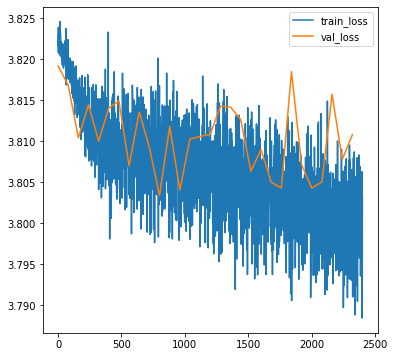

In [55]:
plt.figure(figsize=(6,6))
plt.plot(losses, label='train_loss')
plt.plot(np.arange(0, len(losses), int(len(losses)/len(val_losses))), val_losses, label='val_loss')
plt.legend()
plt.show()

In [56]:
idx = [(x, y) for x in range(200) for y in range(200)]

In [58]:
prob = net.forward(torch.from_numpy(np.array(idx)))
prob = prob.reshape(200,200).T.detach().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


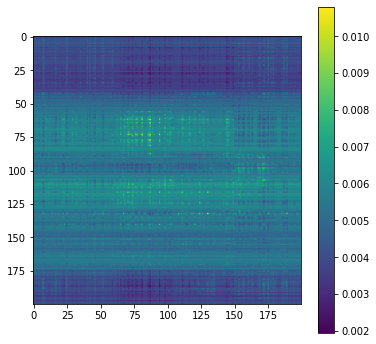

In [60]:
plt.figure(figsize=(6,6))
plt.imshow(prob)
plt.colorbar()
plt.show()